# Importing Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# Load Dataset

In [4]:
df = pd.read_csv("loan_prediction.csv")

 # Exploratory Data Analysis

/var/folders/px/crxq_yw10090rp6hn0w1krqm0000gn/T/ipykernel_22736/1136663681.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Loan_Status', data=df, palette='Set2')


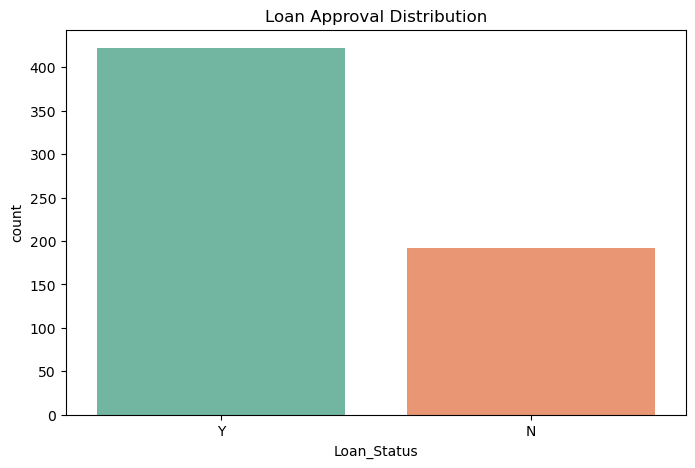

In [7]:
plt.figure(figsize=(8,5))
sns.countplot(x='Loan_Status', data=df, palette='Set2')
plt.title("Loan Approval Distribution")
plt.show()


# Visualizing numerical features

<Figure size 1200x600 with 0 Axes>

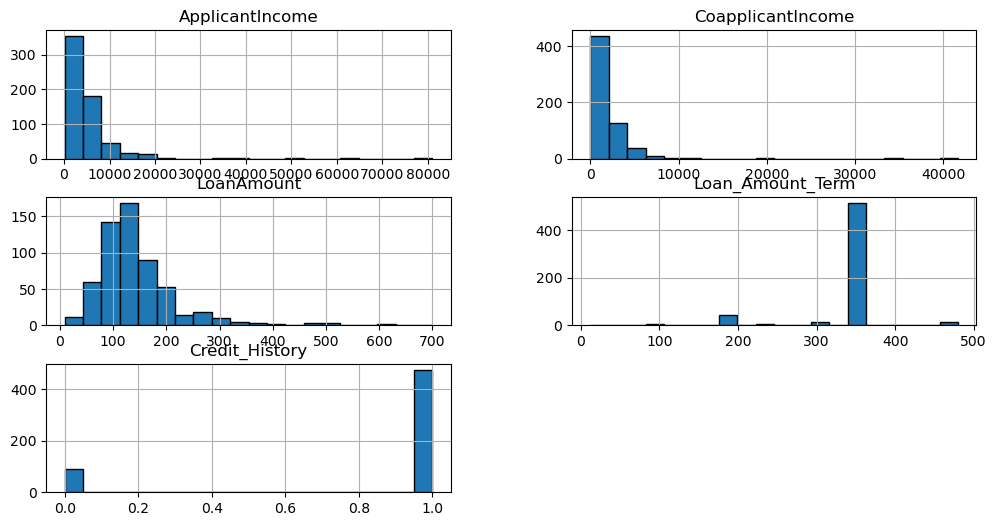

In [10]:
plt.figure(figsize=(12, 6))
df.hist(bins=20, figsize=(12, 6), edgecolor='black')
plt.show()

# Correlation heatmap

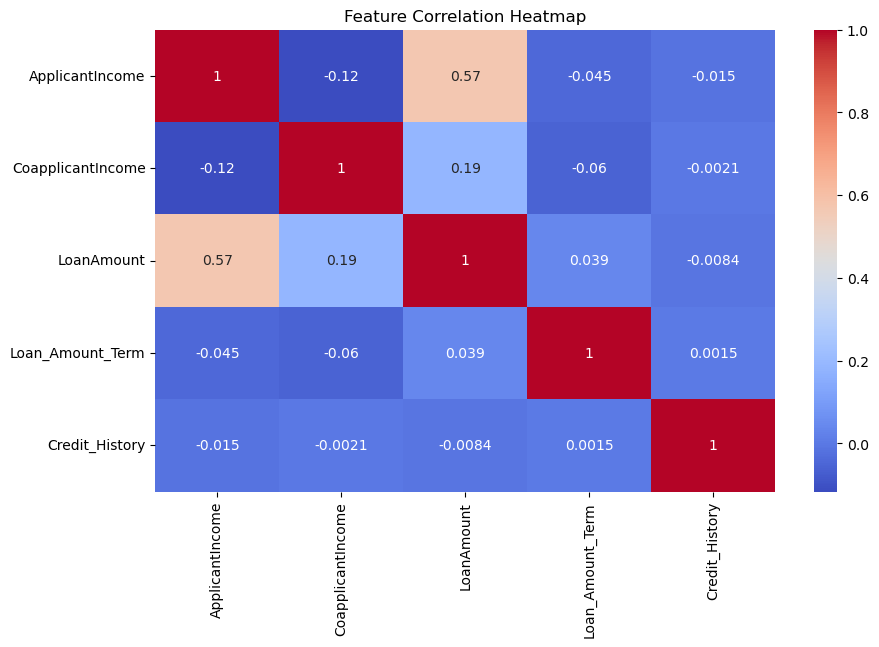

In [13]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

# Data Preprocessing
# Handling missing values

In [16]:
df.fillna(df.mean(numeric_only=True), inplace=True)
def fill_categorical(col):
    return df[col].fillna(df[col].mode()[0])

for col in df.select_dtypes(include=['object']).columns:
    df[col] = fill_categorical(col)


# Encoding categorical variables

In [19]:
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le


# Splitting Data for Training and Testing

In [22]:
X = df.drop("Loan_Status", axis=1)
y = df["Loan_Status"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Scaling the data

In [25]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Ensuring y_train is a 1D array

In [32]:
y_train = y_train.values.ravel()

# Model Training and Evaluation

In [35]:
def train_and_evaluate(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\nModel: {model.__class__.__name__}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

models = {
    "Logistic Regression": LogisticRegression(max_iter=5000, solver='saga'),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Support Vector Machine": SVC(kernel='linear', random_state=42),
    "XGBoost": XGBClassifier(learning_rate=0.1, max_depth=3, scale_pos_weight=1.5)
}

trained_models = {}
for name, model in models.items():
    print("\n==============================")
    print(f"Training: {name}")
    train_and_evaluate(model, X_train, X_test, y_train, y_test)
    trained_models[name] = model
    joblib.dump(model, f"{name.replace(' ', '_').lower()}_model.pkl")


Training: Logistic Regression

Model: LogisticRegression
Accuracy: 0.7886
Confusion Matrix:
 [[18 25]
 [ 1 79]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.42      0.58        43
           1       0.76      0.99      0.86        80

    accuracy                           0.79       123
   macro avg       0.85      0.70      0.72       123
weighted avg       0.83      0.79      0.76       123


Training: Decision Tree

Model: DecisionTreeClassifier
Accuracy: 0.7154
Confusion Matrix:
 [[25 18]
 [17 63]]
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.58      0.59        43
           1       0.78      0.79      0.78        80

    accuracy                           0.72       123
   macro avg       0.69      0.68      0.69       123
weighted avg       0.71      0.72      0.71       123


Training: Random Forest

Model: RandomForestClassifier
Accuracy: 0.7805
C

 # Save the scaler and encoders

In [38]:
joblib.dump(scaler, "scaler.pkl")
joblib.dump(label_encoders, "label_encoders.pkl")

['label_encoders.pkl']

# Feature Importance (Random Forest)

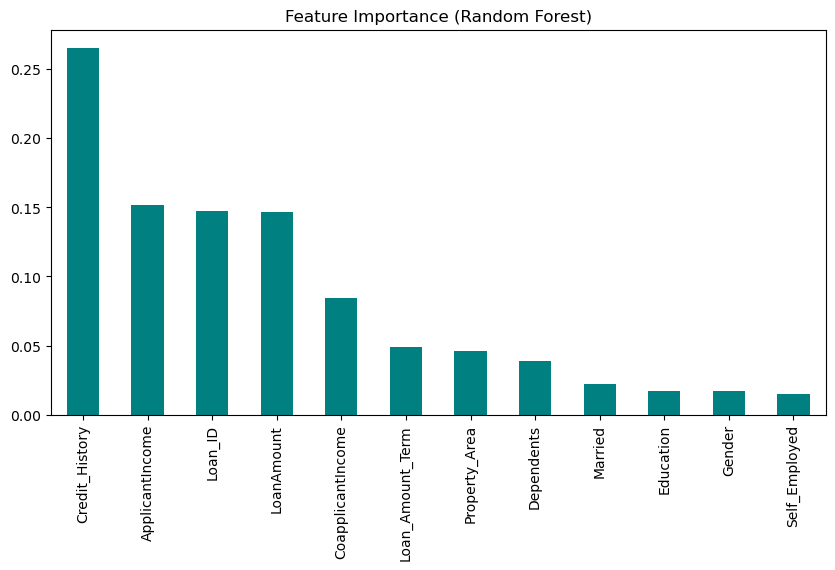

In [41]:
rf_model = trained_models["Random Forest"]
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar', figsize=(10, 5), color='teal')
plt.title("Feature Importance (Random Forest)")
plt.show()

# Function to Predict Loan Eligibility

In [86]:
def predict_loan_eligibility(model_filename, input_data):
    model = joblib.load(model_filename)
    scaler = joblib.load("scaler.pkl")
    label_encoders = joblib.load("label_encoders.pkl")
    input_df = pd.DataFrame([input_data])

    # Ensure input_df has the same columns as original dataset
    for col in X.columns:
        if col not in input_df.columns:
            input_df[col] = np.nan  # Add missing columns
    
    for col in input_df.select_dtypes(include=['object']).columns:
        input_df[col] = input_df[col].fillna(df[col].mode()[0])
    input_df.fillna(df.mean(numeric_only=True), inplace=True)

    # Encode categorical variables safely
    for col, le in label_encoders.items():
        if col in input_df.columns:
            input_df[col] = input_df[col].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)

    # Ensure the order of columns matches the training data
    input_df = input_df[X.columns]  # Align input features

    input_scaled = scaler.transform(input_df)
    prediction = model.predict(input_scaled)
    return "Eligible" if prediction[0] == 1 else "Not Eligible"


# Example Prediction

In [89]:
new_applicant = {
    "Gender": "Male",
    "Married": "Yes",
    "Dependents": "1",
    "Education": "Graduate",
    "Self_Employed": "No",
    "ApplicantIncome": 5000,
    "CoapplicantIncome": 1500,
    "LoanAmount": 200,
    "Loan_Amount_Term": 360,
    "Credit_History": 1,
    "Property_Area": "Urban"
}

for col, le in label_encoders.items():
    if col in new_applicant:
        new_applicant[col] = le.transform([new_applicant[col]])[0] if new_applicant[col] in le.classes_ else -1

selected_model_file = "random_forest_model.pkl"  
result = predict_loan_eligibility(selected_model_file, new_applicant)
print("Loan Eligibility:", result)


Loan Eligibility: Not Eligible
